In [534]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import time
import datetime
from scipy import stats  
import seaborn as sns


In [536]:
tf.random.set_seed(7)


In [538]:
# Load the dataset
dataframe = pd.read_csv('Oil.csv', usecols=[0, 1], engine='python')
dataset = dataframe.iloc[:, 1].values
dataset = dataset.astype('float32').reshape(-1, 1)
print('dataset.shape',dataset.shape ,'\nIts Value', '\n',dataset)

dataset.shape (5531, 1) 
Its Value 
 [[30.05]
 [30.83]
 [30.71]
 ...
 [80.93]
 [82.36]
 [83.1 ]]


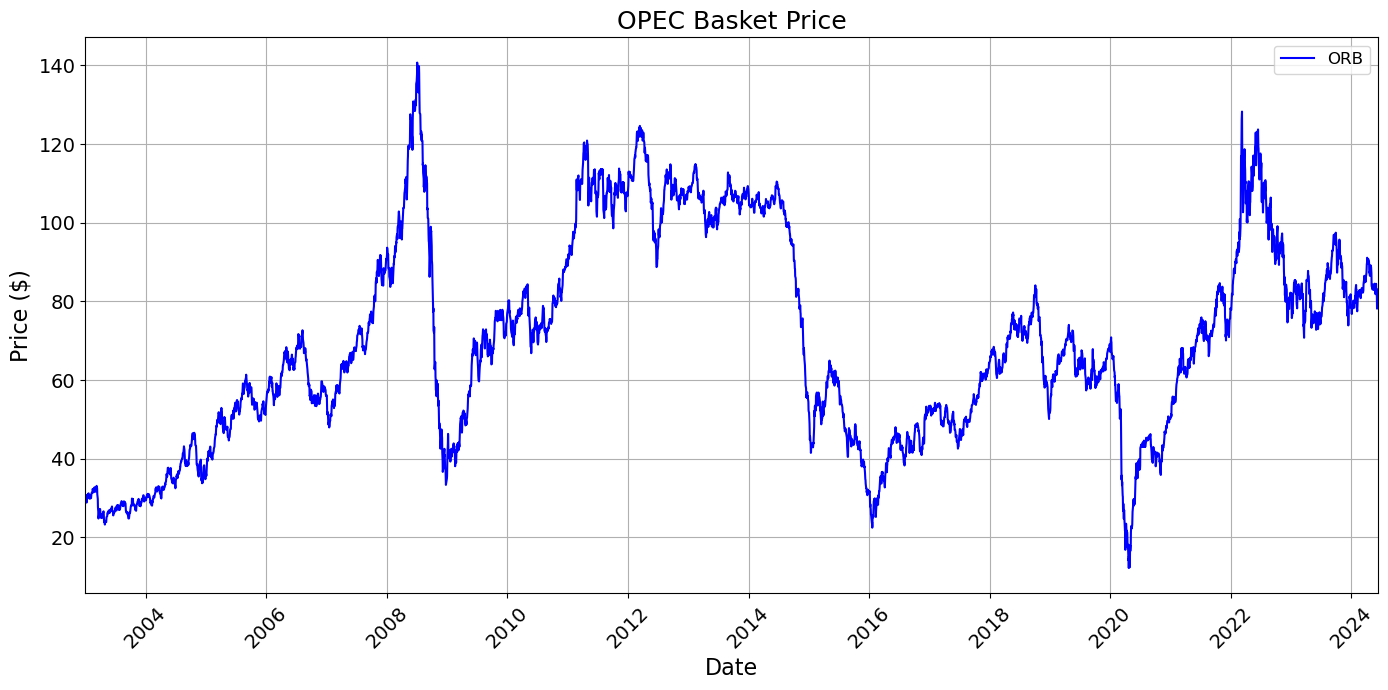

In [540]:
#plot the original Data
date_column = dataframe.columns[0]
# Convert the date column to datetime, specifying the correct format
dates = pd.to_datetime(dataframe[date_column], dayfirst=True)

# Plot the dataset
plt.figure(figsize=(14, 7))
plt.plot(dates, dataset, label='ORB', color='blue')

# Adding title and labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.title('OPEC Basket Price', fontsize=18)

# Configure the x-axis to display dates properly
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
start_date = pd.to_datetime('2003-01-01')
end_date = pd.to_datetime('2024-06-12')
ax.set_xlim([start_date, end_date])

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.legend(fontsize=12)

plt.tight_layout()

# Show the plot
plt.savefig('ORIGINAL_data.png')

plt.show()


In [542]:
# Check for missing values
missing_values_count = np.isnan(dataset).sum()
print(f'Number of missing values: {missing_values_count}')

# Apply backward filling to handle missing values
if missing_values_count > 0:
    dataset = pd.DataFrame(dataset).fillna(method='bfill').values

# Print the updated dataset
print('dataset.shape', dataset.shape, '\nIts Value', '\n', dataset)

Number of missing values: 0
dataset.shape (5531, 1) 
Its Value 
 [[30.05]
 [30.83]
 [30.71]
 ...
 [80.93]
 [82.36]
 [83.1 ]]


In [544]:
mean_value = np.mean(dataset)
std_dev = np.std(dataset)

# Print the results
print(f'Mean of the dataset: {mean_value}')
print(f'Standard Deviation of the dataset: {std_dev}')

Mean of the dataset: 70.16722869873047
Standard Deviation of the dataset: 26.255027770996094


In [546]:
# Outlier removal

z_scores = np.abs(stats.zscore(dataset))
dataset = dataset[z_scores < 3].reshape(-1, 1)

print('Dataset shape after outlier removal:', dataset.shape)

Dataset shape after outlier removal: (5531, 1)


In [548]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print('scaled dataset', '\n',dataset)

scaled dataset 
 [[0.13874406]
 [0.14481363]
 [0.14387985]
 ...
 [0.53466654]
 [0.5457941 ]
 [0.5515524 ]]


In [550]:
# Parameters
split = 0.65
lstm_units = 100
epochs = 10
look_back = 1


In [552]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [554]:

# Split the dataset
train_size = int(len(dataset) * split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Create the dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0], look_back,1))

trainX.shape


(3594, 1, 1)

In [556]:
# Create and fit the LSTM network


model = Sequential()
model.add(LSTM(lstm_units,  input_shape = (look_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)
end_time = time.time()
training_time = end_time - start_time


Epoch 1/10


C:\Users\abo__\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3594/3594 - 10s - 3ms/step - loss: 0.0038
Epoch 2/10
3594/3594 - 6s - 2ms/step - loss: 1.1733e-04
Epoch 3/10
3594/3594 - 5s - 1ms/step - loss: 1.1485e-04
Epoch 4/10
3594/3594 - 5s - 2ms/step - loss: 1.1265e-04
Epoch 5/10
3594/3594 - 6s - 2ms/step - loss: 1.1130e-04
Epoch 6/10
3594/3594 - 6s - 2ms/step - loss: 1.1025e-04
Epoch 7/10
3594/3594 - 6s - 2ms/step - loss: 1.0924e-04
Epoch 8/10
3594/3594 - 7s - 2ms/step - loss: 1.0836e-04
Epoch 9/10
3594/3594 - 5s - 1ms/step - loss: 1.0757e-04
Epoch 10/10
3594/3594 - 7s - 2ms/step - loss: 1.0681e-04


In [558]:

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
#trainRMSE = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
#testRMSE = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))

# MAE
trainMAE = mean_absolute_error(trainY[0], trainPredict[:, 0])
testMAE = mean_absolute_error(testY[0], testPredict[:, 0])
#MAPE
trainMAPE=mean_absolute_percentage_error(trainY[0], trainPredict[:, 0])
testMAPE=mean_absolute_percentage_error(testY[0], testPredict[:, 0])

print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')

print(f'Train Score: {trainMAE:.2f} MAE')
print(f'Test Score: {testMAE:.2f} MAE')

print(f'Train Score: {trainMAPE:.2f} MAPE')
print(f'Test Score: {testMAPE:.2f} MAPE')

print(f'Training Time: {training_time:.2f} seconds')


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 1.10 RMSE
Test Score: 1.44 RMSE
Train Score: 0.81 MAE
Test Score: 0.99 MAE
Train Score: 0.01 MAPE
Test Score: 0.02 MAPE
Training Time: 64.23 seconds


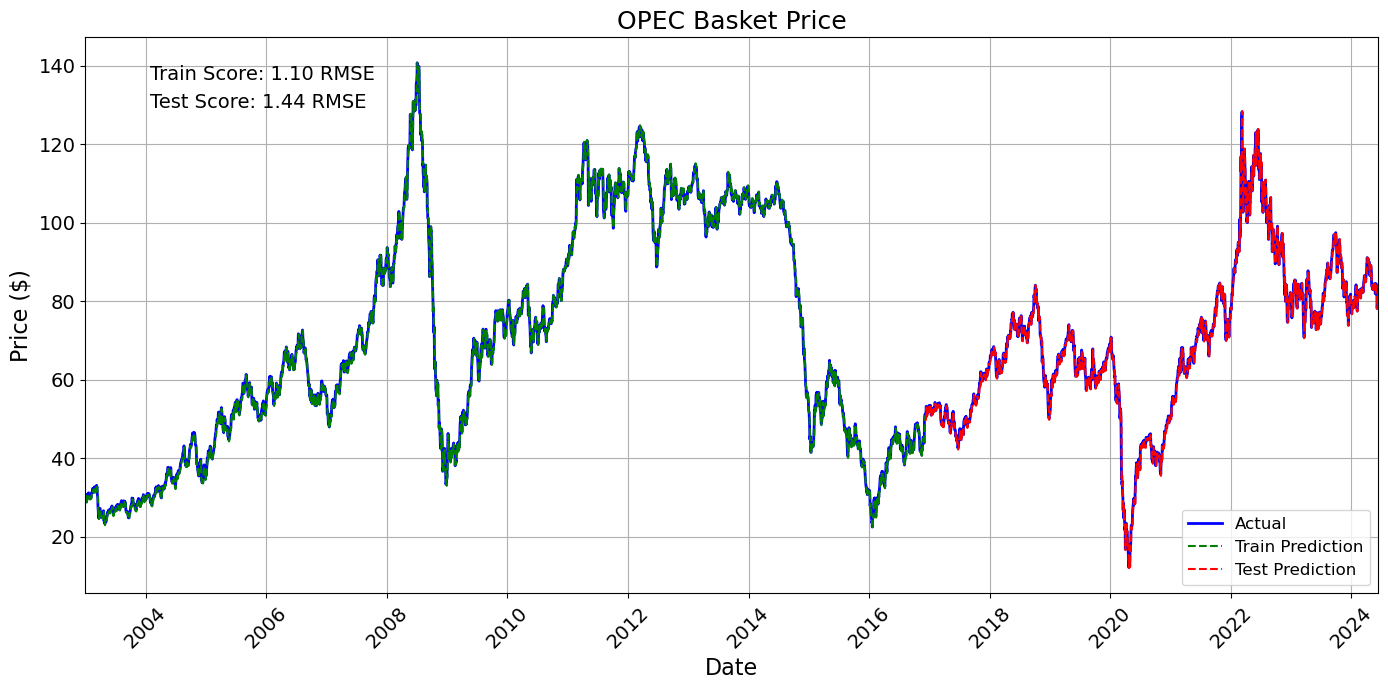

In [560]:

# Extract the dates from the original data frame
date_column = dataframe.columns[0]
dataframe[date_column] = pd.to_datetime(dataframe[date_column], format='%d/%m/%Y')
dates = dataframe[date_column].values

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2):len(trainPredict) + (look_back * 2) + len(testPredict), :] = testPredict

# Plot baseline and predictions
plt.figure(figsize=(14, 7))
plt.plot(dates, scaler.inverse_transform(dataset), label='Actual', color='blue', linewidth=2)  # Increase linewidth
plt.plot(dates, trainPredictPlot, label='Train Prediction', color='green', linestyle='--')
plt.plot(dates, testPredictPlot, label='Test Prediction', color='red', linestyle='--')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Price ($)',fontsize=16)
plt.title('OPEC Basket Price',fontsize=18)

# Add train and test scores
plt.text(0.05, 0.95, f'Train Score: {trainScore:.2f} RMSE', transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top')
plt.text(0.05, 0.90, f'Test Score: {testScore:.2f} RMSE', transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top')

plt.legend(loc='lower right',fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
start_date = pd.to_datetime('2003-01-01')
ax.set_xlim([start_date, dataframe[date_column].max()])

plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


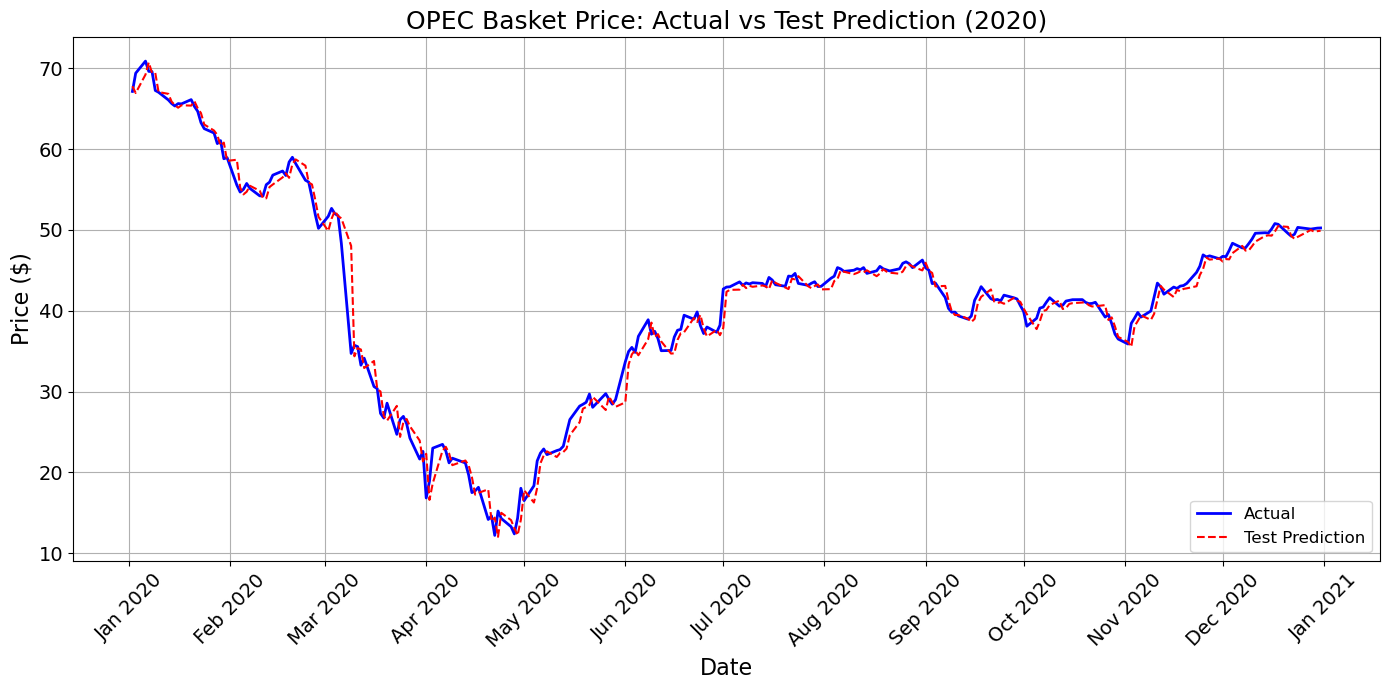

In [562]:

# Convert dates to a pandas datetime format for easier filtering
dates = pd.to_datetime(dates)

# Filter data for the year 2020
mask = (dates >= pd.to_datetime('2020-01-01')) & (dates <= pd.to_datetime('2020-12-31'))
dates_2020 = dates[mask]
actual_2020 = scaler.inverse_transform(dataset)[mask]
test_2020 = testPredictPlot[mask]

# Plot actual vs. test predictions for the year 2020
plt.figure(figsize=(14, 7))
plt.plot(dates_2020, actual_2020, label='Actual', color='blue', linewidth=2)
plt.plot(dates_2020, test_2020, label='Test Prediction', color='red', linestyle='--')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.title('OPEC Basket Price: Actual vs Test Prediction (2020)', fontsize=18)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Format the x-axis for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('Zoomed2020.png')

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Validation Score: 1.02 RMSE
Validation Score: 0.76 MAE
Validation Score: 0.01 MAPE


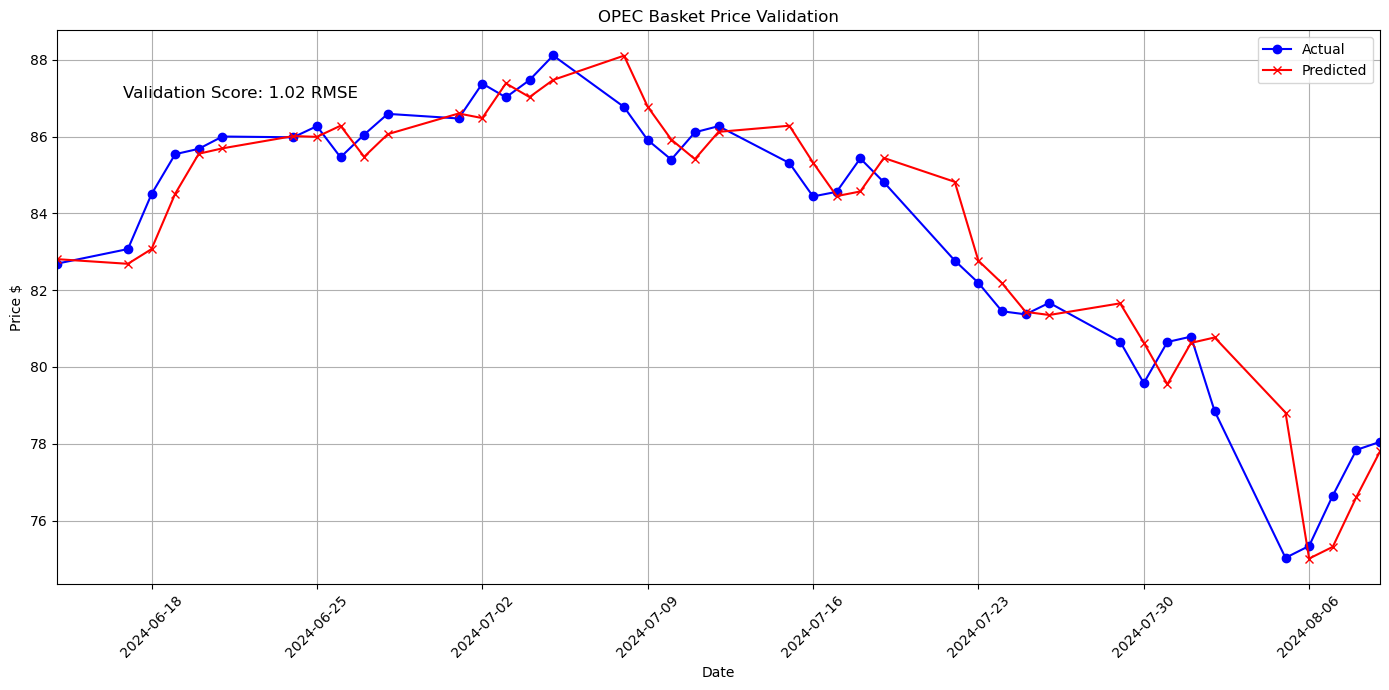

1    2024-06-14
2    2024-06-17
3    2024-06-18
4    2024-06-19
5    2024-06-20
6    2024-06-21
7    2024-06-24
8    2024-06-25
9    2024-06-26
10   2024-06-27
11   2024-06-28
12   2024-07-01
13   2024-07-02
14   2024-07-03
15   2024-07-04
16   2024-07-05
17   2024-07-08
18   2024-07-09
19   2024-07-10
20   2024-07-11
21   2024-07-12
22   2024-07-15
23   2024-07-16
24   2024-07-17
25   2024-07-18
26   2024-07-19
27   2024-07-22
28   2024-07-23
29   2024-07-24
30   2024-07-25
31   2024-07-26
32   2024-07-29
33   2024-07-30
34   2024-07-31
35   2024-08-01
36   2024-08-02
37   2024-08-05
38   2024-08-06
39   2024-08-07
40   2024-08-08
41   2024-08-09
Name: Date, dtype: datetime64[ns]

In [526]:
valid_data = pd.read_csv('VaildData.csv', usecols=[0, 1], engine='python')
valid_data.columns = ['Date', 'Price']
valid_data['Date'] = pd.to_datetime(valid_data['Date'], format='%d/%m/%Y')
dates = valid_data['Date']
scaler = MinMaxScaler(feature_range=(0, 1))
valid_data_Values = scaler.fit_transform(valid_data['Price'].values.astype('float32').reshape(-1, 1))
# Prepare the test data for prediction
VaildDataX, VaildDataY = create_dataset(valid_data_Values, look_back)

# Reshape input to be [samples, time steps, features]
VaildDataX = np.reshape(VaildDataX, (VaildDataX.shape[0], look_back, 1))

# Make predictions
VaildDataPredict = model.predict(VaildDataX)

# Invert predictions
VaildDataPredict = scaler.inverse_transform(VaildDataPredict)
VaildDataY = scaler.inverse_transform(VaildDataY.reshape(-1, 1))
valid_data_dates = dates[look_back:look_back + len(VaildDataPredict)]
VaildDataY = np.array(VaildDataY).reshape(-1)  # Reshape to (41,)
VaildDataPredict = np.array(VaildDataPredict)

# RMSE Vaildation
VaildDataScoreRMSE = np.sqrt(mean_squared_error(VaildDataY,VaildDataPredict[:, 0] ))
print(f'Validation Score: {VaildDataScoreRMSE:.2f} RMSE')

# MAE
VaildDataScoreMAE = mean_absolute_error(VaildDataY, VaildDataPredict[:, 0])
print(f'Validation Score: {VaildDataScoreMAE:.2f} MAE')
#MAPE
VaildDataScoreMAPE = mean_absolute_percentage_error(VaildDataY, VaildDataPredict[:, 0])

print(f'Validation Score: {VaildDataScoreMAPE:.2f} MAPE')

plt.figure(figsize=(14, 7))
plt.plot(valid_data_dates, VaildDataY, label='Actual', color='blue', marker='o')
plt.plot(valid_data_dates, VaildDataPredict, label='Predicted', color='red', marker='x')
plt.text(0.05, 0.90, f'Validation Score: {VaildDataScoreRMSE:.2f} RMSE', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top')
# Formatting the plot
# Formatting the plot
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.title('OPEC Basket Price Validation', fontsize=18)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
start_date = pd.to_datetime('2024-06-14')
ax.set_xlim([start_date, dates.max()])

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('The Validation Test.png')
plt.show()

